In [1]:
!pip install transformers
!pip install sentencepiece
!pip3 install mvlearn

from google.colab import drive
drive.mount('/content/drive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.1 MB/s 
     |████████████████████████████████| 6.6 MB 45.5 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 596 kB 45.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERR

In [2]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 4.1 MB/s 


In [3]:
import os
os.chdir('drive/MyDrive/William_2022/DATASETS/main_trans_ZuCo')

import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from model_new import Transformer, Transformer2, Encoder
from config import *
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from tqdm import tqdm
from optim_new import ScheduledOptim
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
from CCA import DeepCCA, cca_loss
from scipy.stats import wasserstein_distance
from mvlearn.embed import DCCA
from mvlearn.datasets import make_gaussian_mixture
from mvlearn.plotting import crossviews_plot
from dataset_new import Fusion

In [4]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

class EEGDataset(Dataset):
    def __init__(self, signal, label):

        self._signal = torch.FloatTensor(signal)
        self._label = torch.LongTensor(label)


    @property
    def n_insts(self):
        ''' Property for dataset size '''
        return len(self._label)

    @property
    def sig_len(self):
        return self._signal.shape[1]

    def __len__(self):
        return self.n_insts

    def __getitem__(self, idx):
        return self._signal[idx], self._label[idx]

class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  @property
  def n_insts(self):
    return len(self.labels)

  @property
  def text_len(self):
    return 32

  def __len__(self):
    return self.n_insts

  def __getitem__(self, item):
    text = str(self.texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length = True,
      return_attention_mask=True
      #return_tensors='pt',
    )
    return torch.FloatTensor(encoding['input_ids']).flatten(), torch.tensor(label, dtype=torch.long)



Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [5]:
emotion = 'sentiment'

In [6]:
df = pd.read_csv(f'preprocessed_eeg/{patient}_mean.csv')

X = df.drop([emotion], axis = 1)
y= df[[emotion]]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 2, test_size = 0.3, shuffle = True)
ros = RandomOverSampler(random_state=2)
X_resampled_text, y_resampled_text = ros.fit_resample(X_train, y_train)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state= 2, test_size = 0.5, shuffle = True)
df_test = pd.concat([X_test, y_test], axis = 1)
df_train = pd.concat([X_resampled_text, y_resampled_text], axis = 1)
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = pd.concat([X_val, y_val], axis = 1)

df_train_text = df_train[[emotion, 'new_words']]
df_train_eeg_label = df_train[[emotion]]
df_train_eeg = df_train.iloc[:, 3:]
df_train_eeg = pd.concat([df_train_eeg_label, df_train_eeg], axis=1)

df_val_text = df_val[[emotion, 'new_words']]
df_val_eeg_label = df_val[[emotion]]
df_val_eeg = df_val.iloc[:, 3:]
df_val_eeg = pd.concat([df_val_eeg_label, df_val_eeg], axis=1)

df_test_text = df_test[[emotion, 'new_words']]
df_test_eeg_label = df_test[[emotion]]
df_test_eeg = df_test.iloc[:, 3:]
df_test_eeg = pd.concat([df_test_eeg_label, df_test_eeg], axis=1)

In [ ]:
eeg = [emotion, 'delta0', 'lowAlpha0', 'highAlpha0','lowBeta0','highBeta0', 'lowGamma0', 'middleGamma0', 'theta0',
         'delta1', 'lowAlpha1', 'highAlpha1', 'lowBeta1', 'highBeta1', 'lowGamma1', 'middleGamma1', 'theta1',
         'delta2', 'lowAlpha2', 'highAlpha2', 'lowBeta2', 'highBeta2', 'lowGamma2', 'middleGamma2', 'theta2',
         'delta3', 'lowAlpha3', 'highAlpha3', 'lowBeta3', 'highBeta3', 'lowGamma3', 'middleGamma3', 'theta3',
         'delta4', 'lowAlpha4', 'highAlpha4', 'lowBeta4', 'highBeta4', 'lowGamma4', 'middleGamma4', 'theta4',
         'delta5', 'lowAlpha5', 'highAlpha5', 'lowBeta5', 'highBeta5', 'lowGamma5', 'middleGamma5', 'theta5']


In [ ]:
df = pd.read_csv('df.csv')

X = df.drop([emotion], axis = 1)
y= df[[emotion]]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 2, test_size = 0.3, shuffle = True, stratify = y)
ros = RandomOverSampler(random_state=2)
X_resampled_text, y_resampled_text = ros.fit_resample(X_train, y_train)



X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state= 2, test_size = 0.5, shuffle = True, stratify = y_val)
df_test = pd.concat([X_test, y_test], axis = 1)
df_train = pd.concat([X_resampled_text, y_resampled_text], axis = 1)
# df_train = pd.concat([X_train, y_train], axis = 1)
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = pd.concat([X_val, y_val], axis = 1)

df_train_text = df_train[[emotion, 'new_words']]
df_train_eeg = df_train[eeg]

df_val_text = df_val[[emotion, 'new_words']]
df_val_eeg = df_val[eeg]

df_test_text = df_test[[emotion, 'new_words']]
df_test_eeg = df_test[eeg]

In [7]:
sentences_train = df_train_text.new_words
sentences_val = df_val_text.new_words
sentences_test = df_test_text.new_words

In [8]:
input_ids_train = [tokenizer.encode(sent, add_special_tokens=False,max_length=MAX_LEN,pad_to_max_length=True, return_token_type_ids = False, return_attention_mask = True) for sent in sentences_train]
input_ids_val = [tokenizer.encode(sent, add_special_tokens=False,max_length=MAX_LEN,pad_to_max_length=True, return_token_type_ids = False, return_attention_mask = True) for sent in sentences_val]
input_ids_test = [tokenizer.encode(sent, add_special_tokens=False,max_length=MAX_LEN,pad_to_max_length=True, return_token_type_ids = False, return_attention_mask = True) for sent in sentences_test]


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [9]:
text_train = np.array(input_ids_train)
text_val = np.array(input_ids_val)
text_test = np.array(input_ids_test)

In [10]:
text_train = text_train/np.linalg.norm(text_train)
text_val = text_val/np.linalg.norm(text_val)
text_test = text_test/np.linalg.norm(text_test)

In [11]:
df_train_eeg = df_train_eeg.values
df_val_eeg = df_val_eeg.values
df_test_eeg = df_test_eeg.values

eeg_train = df_train_eeg[:, 1:]
eeg_val = df_val_eeg[:, 1:] 
eeg_test = df_test_eeg[:, 1:]

In [12]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [ ]:
Xs = []
Xs.append(text_train)
Xs.append(eeg_train)

In [ ]:
Xs_test = []
Xs_test.append(text_test)
Xs_test.append(eeg_test)

In [83]:
y_train = y_resampled_text.values
y_test = y_test.values
y_val = y_val.values

In [ ]:
y_train.flatten()

array([1, 1, 2, 0, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 0, 2, 1, 0, 0, 1, 0, 2,
       0, 2, 0, 1, 1, 2, 0, 2, 0, 1, 0, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 2,
       1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 0,
       2, 0, 0, 2, 1, 2, 1, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 0,
       2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 1, 1, 2, 2, 0, 0, 2, 2, 1, 1, 0, 2,
       2, 1, 1, 2, 0, 0, 1, 1, 2, 0, 2, 2, 2, 0, 1, 1, 0, 2, 2, 2, 2, 0,
       1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 0, 2, 1, 0, 1, 0, 0,
       0, 2, 0, 2, 1, 1, 2, 0, 1, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 1, 2, 0, 0, 0,
       0, 2, 2, 0, 1, 1, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 2, 1, 1, 2, 2, 0, 0, 2, 2, 0, 1, 1, 0, 1, 0, 2, 2, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 0, 2, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
features1 = Xs[0].shape[1]  
features2 = Xs[1].shape[1]
layers1 = [256, 256, 4]  
layers2 = [256, 256, 4]

dcca = DCCA(input_size1=features1, input_size2=features2, n_components=4,
            layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=500)
dcca.fit(Xs)
Xs_transformed = dcca.transform(Xs_test)

/usr/local/lib/python3.7/dist-packages/mvlearn/embed/dcca.py:214: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2524.)
  [D1, V1] = torch.symeig(SigmaHat11, eigenvectors=True)


In [ ]:
Xs_transformed_train = dcca.transform(Xs)

In [ ]:
# --- DCCA DS
# --- Trans 

# text_train_ds_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_tran_all_pred_train.txt')
text_test_ds_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_tran_all_pred.txt')
text_val_ds_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_tran_all_pred_val.txt')

text_y_test_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_tran_all_label.txt')
# text_y_train_trans= np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_tran_all_label_train.txt')
text_y_val_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_tran_all_label_val.txt')

# eeg_train_ds_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_tran_all_pred_train.txt')
eeg_test_ds_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_tran_all_pred.txt')
eeg_val_ds_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_tran_all_pred_val.txt')

eeg_y_test_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_tran_all_label.txt')
# eeg_y_train_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_tran_all_label_train.txt')
eeg_y_val_trans = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_tran_all_label_val.txt')


# --- Linear

# text_train_ds_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_lin_all_pred_train.txt')
text_test_ds_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_lin_all_pred.txt')
text_val_ds_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_lin_all_pred_val.txt')

text_y_test_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_lin_all_label.txt')
# text_y_train_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_lin_all_label_train.txt')
text_y_val_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlytext_lin_all_label_val.txt')

# eeg_train_ds_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_lin_all_pred_train.txt')
eeg_test_ds_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_lin_all_pred.txt')
eeg_val_ds_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_lin_all_pred_val.txt')

eeg_y_test_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_lin_all_label.txt')
# eeg_y_train_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_lin_all_label_train.txt')
eeg_y_val_lin = np.loadtxt('baselines/DCCA_ds/arousal_trans_baseline_onlyeeg_lin_all_label_val.txt')


# --- DCCA
# --- Trans
# text_train_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_pred_train.txt')
text_test_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_pred_test.txt')
text_val_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_pred_val.txt')

# eeg_train_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_pred2_train.txt')
eeg_test_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_pred2_test.txt')
eeg_val_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_pred2_val.txt')

# y_train_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_label_train.txt')
y_test_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_label_test.txt')
y_val_DCCA_trans = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_tran_all_label_val.txt')

# --- Linear

# text_train_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_pred_train.txt')
text_val_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_pred_test.txt')
text_test_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_pred_val.txt')

# eeg_train_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_pred2_train.txt')
eeg_test_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_pred2_test.txt')
eeg_val_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_pred2_val.txt')

# y_train_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_label_train.txt')
y_test_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_label_test.txt')
y_val_DCCA_lin = np.loadtxt('baselines/DCCA/arousal_trans_baseline_DCCA_only_lin_all_label_val.txt')

In [ ]:
len(eeg_train)

2181

In [ ]:
len(eeg_val)

244

In [ ]:
len(eeg_val_DCCA_trans)

81400

In [ ]:
text_eeg_train_ds = [eeg_val, eeg_val_DCCA_trans[0:244]]

In [ ]:
text_eeg_train_ds[0][0]

array([-0.253,  0.028, -0.308, -0.221, -0.372, -0.417,  2.315,  0.386,
       -0.354, -0.29 , -0.341, -0.424, -0.425, -0.394,  1.764,  0.022,
       -0.435, -0.433, -0.446, -0.444, -0.433, -0.417,  0.912, -0.324,
       -0.285, -0.393, -0.427, -0.384, -0.453, -0.433,  4.95 ,  0.13 ,
       -0.409, -0.401, -0.416, -0.425, -0.402, -0.442,  2.436, -0.221,
       -0.394, -0.311, -0.43 , -0.417, -0.44 , -0.445,  1.195,  0.12 ])

In [ ]:
len(text_val_DCCA)

81400

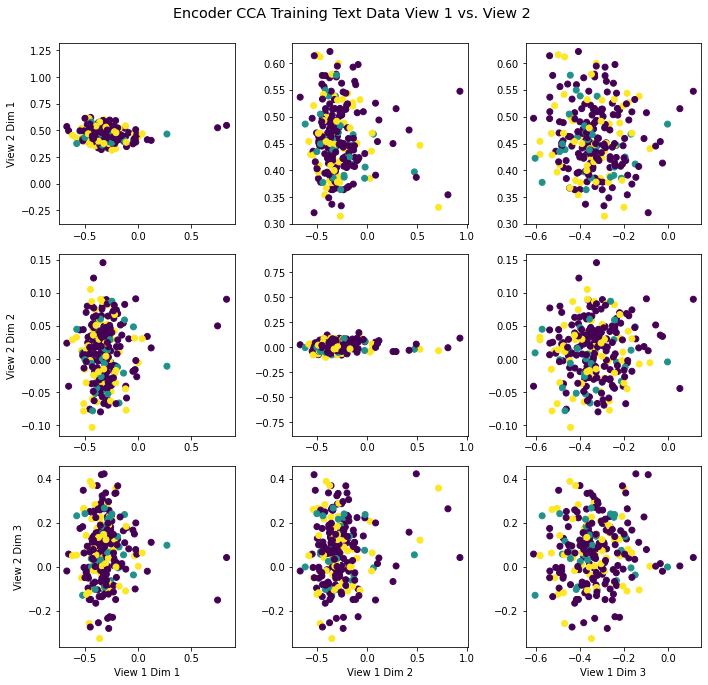

In [ ]:
crossviews_plot(text_eeg_train_ds, labels=y_val_DCCA_trans[0:244],
                title='Encoder CCA Training Text Data View 1 vs. View 2 ',
                equal_axes=True)

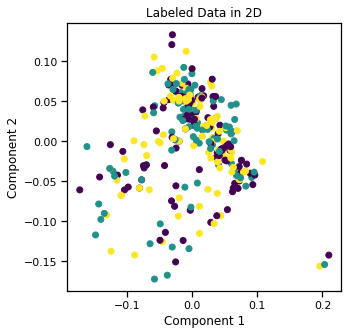

In [ ]:
from mvlearn.plotting import quick_visualize

quick_visualize(Xs, labels=y_train, title='Labeled Data in 2D', figsize=(5, 5))

In [ ]:
### angry

# #Text
# X_train_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_train.txt')
# X_test_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_test.txt')
# X_val_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_val.txt')

# #EEG
# X_train_angry_eeg= np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_train.txt')
# X_test_angry_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_test.txt')
# X_val_angry_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_val.txt')

# #Label
# y_train_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_train.txt')
# y_test_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_test.txt')
# y_val_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_val.txt')


#Text
X_train_arousal_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_lin_all_pred_train.txt')
X_test_arousal_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_lin_all_pred.txt')
X_val_arousal_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_lin_all_pred_val.txt')

#EEG
X_train_arousal_eeg= np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_pred_train.txt')
X_test_arousal_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_pred.txt')
X_val_arousal_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_pred_val.txt')

#Label
y_train_arousal = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_label_train.txt')
y_test_arousal = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_label.txt')
y_val_arousal = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_label_val.txt')



In [ ]:
X_train_angry_eeg = X_train_angry_eeg/np.linalg.norm(X_train_angry_eeg)
X_test_angry_eeg = X_test_angry_eeg/np.linalg.norm(X_test_angry_eeg)
X_val_angry_eeg = X_val_angry_eeg/np.linalg.norm(X_val_angry_eeg)

X_train_arousal_eeg = X_train_arousal_eeg/np.linalg.norm(X_train_arousal_eeg)
X_test_arousal_eeg = X_test_arousal_eeg/np.linalg.norm(X_test_arousal_eeg)
X_val_arousal_eeg = X_val_arousal_eeg/np.linalg.norm(X_val_arousal_eeg)

In [ ]:
# Xs_train_angry = []
# Xs_train_angry.append(X_train_angry_text)
# Xs_train_angry.append(X_train_angry_eeg)

# Xs_test_angry = []
# Xs_test_angry.append(X_test_angry_text)
# Xs_test_angry.append(X_test_angry_eeg)

# Xs_val_angry = []
# Xs_val_angry.append(X_val_angry_text)
# Xs_val_angry.append(X_val_angry_eeg)


Xs_train_arousal = []
Xs_train_arousal.append(X_train_arousal_text)
Xs_train_arousal.append(X_train_arousal_eeg)

Xs_test_arousal = []
Xs_test_arousal.append(X_test_arousal_text)
Xs_test_arousal.append(X_test_arousal_eeg)

Xs_val_arousal = []
Xs_val_arousal.append(X_val_arousal_text)
Xs_val_arousal.append(X_val_arousal_eeg)

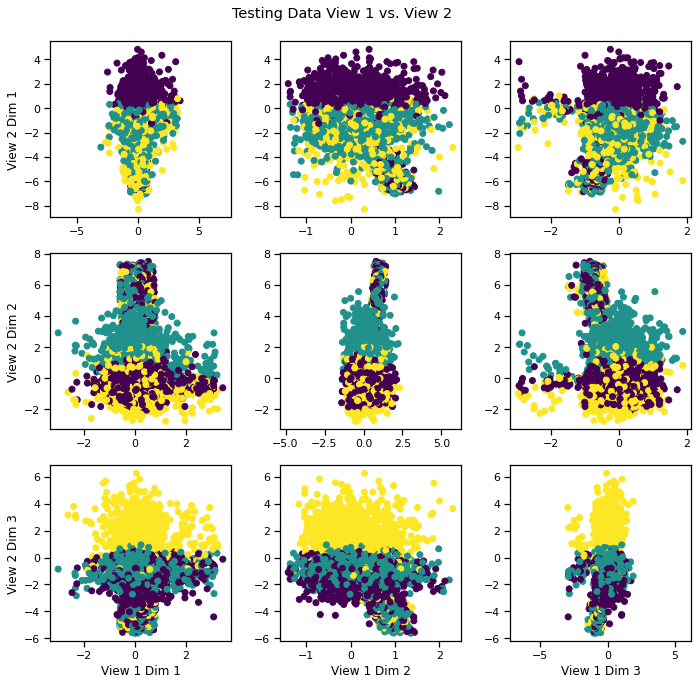

In [ ]:
#trans
crossviews_plot(Xs_val_arousal, labels=y_val_arousal ,
                title='Testing Data View 1 vs. View 2 ',
                equal_axes=True)

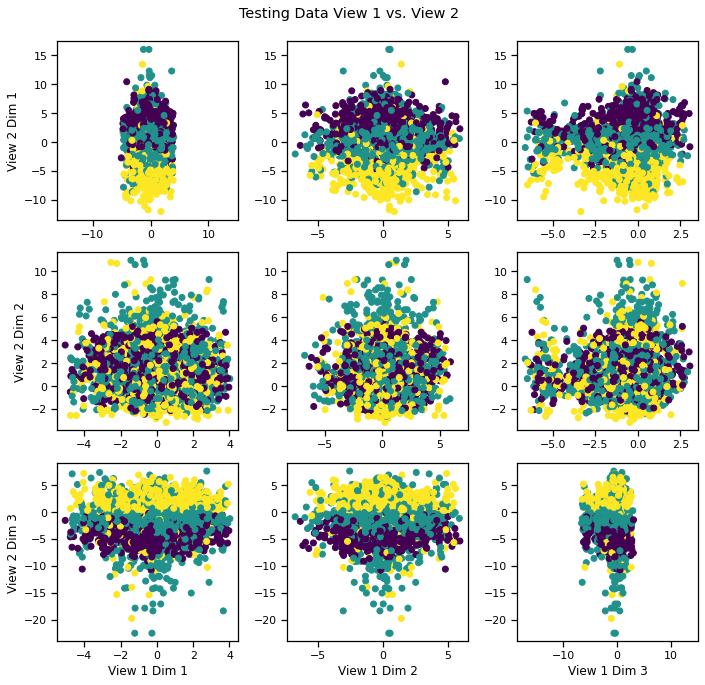

In [ ]:
#linear
crossviews_plot(Xs_val_arousal, labels=y_val_arousal ,
                title='Testing Data View 1 vs. View 2 ',
                equal_axes=True)

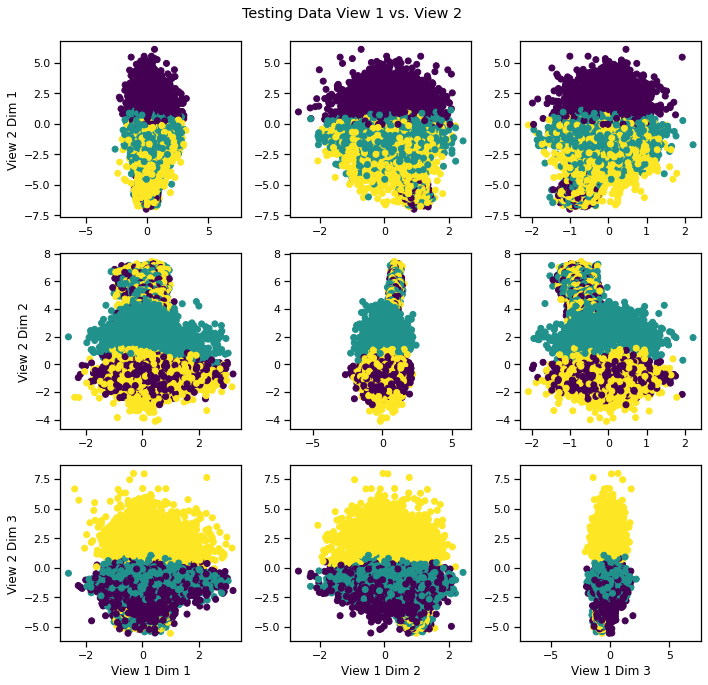

In [ ]:
#trans
crossviews_plot(Xs_train_arousal, labels=y_train_arousal ,
                title='Testing Data View 1 vs. View 2 ',
                equal_axes=True)

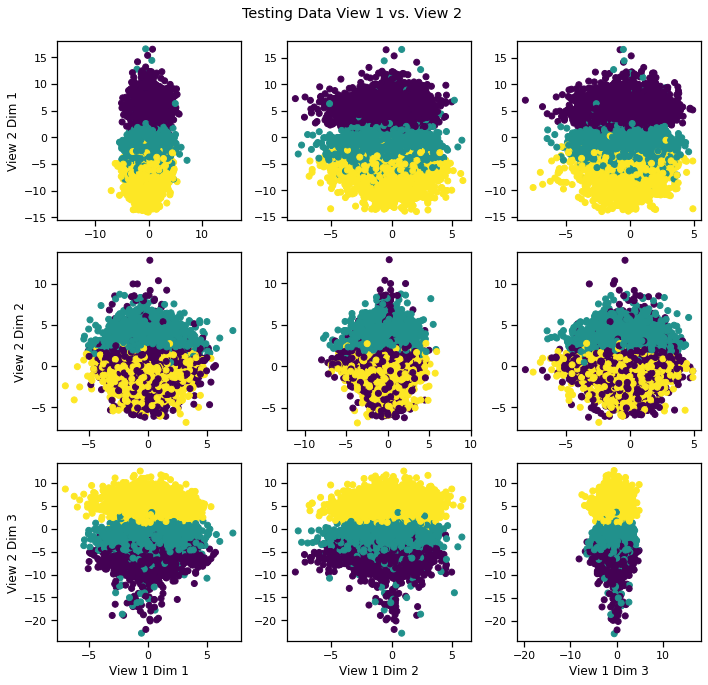

In [ ]:
#lin
crossviews_plot(Xs_train_arousal, labels=y_train_arousal ,
                title='Testing Data View 1 vs. View 2 ',
                equal_axes=True)

In [14]:
#Text
X_test_arousal_text_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred.txt')
X_val_arousal_text_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred_val.txt')

#EEG
X_test_arousal_eeg_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred.txt')
X_val_arousal_eeg_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred_val.txt')

#Label
y_test_arousal_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label.txt')
y_val_arousal_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label_val.txt')

In [ ]:
#Text
X_train_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_train.txt')
X_test_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_test.txt')
X_val_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_val.txt')

#EEG
X_train_angry_eeg= np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_train.txt')
X_test_angry_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_test.txt')
X_val_angry_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_val.txt')

#Label
y_train_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_train.txt')
y_test_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_test.txt')
y_val_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_val.txt')

In [ ]:
from scipy.stats import wasserstein_distance
import cv2

def get_histogram(img):
  # img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  h, w = img.shape
  #w,h = img.shape[:2][::-1]
  hist = [0.0] * 256
  for i in range(h):
    for j in range(w):
      hist[img[i, j]] += 1
  return np.array(hist) / (h * w)

def get_WD_distance(a,b):
    a_hist = get_histogram(a)
    b_hist = get_histogram(b)
    dist = wasserstein_distance(a_hist, b_hist)
    return dist


In [ ]:
zuco_eeg[0,1]

0.213004469871521

In [ ]:
np.unique(zuco_eeg)

array([-0.55621523, -0.53573793, -0.51977187, -0.51293147, -0.48670852,
       -0.45255154, -0.44809332, -0.43071091, -0.37130129, -0.33826339,
       -0.33695787, -0.3324399 , -0.32805729, -0.31336218, -0.31280491,
       -0.30770981, -0.29785943, -0.29085633, -0.28083938, -0.27908307,
       -0.26784977, -0.21179074, -0.05255587,  0.21300447])

In [ ]:
get_histogram(zuco_eeg)

TypeError: ignored

In [ ]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=20, s=5)  # m= mean, s= std
b = gauss(n, m=60, s=10)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()

In [ ]:
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [ ]:
text_only= np.loadtxt('baselines/text/arousal_trans_baseline_onlytext_all_pred.txt')

eeg_only = np.loadtxt('baselines/eeg/arousal_trans_baseline_onlyeeg_all_pred.txt')

In [ ]:
zuco_text = np.loadtxt('../main_trans_ZuCo/baselines/text/sentiment_baseline_onlytext_all_pred.txt')
zuco_eeg = np.loadtxt('../main_trans_ZuCo/baselines/eeg/sentiment_baseline_onlyeeg_all_pred.txt')

zuco_dcca_text = np.loadtxt('../main_trans_ZuCo/baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred_train.txt')
zuco_dcca_eeg = np.loadtxt('../main_trans_ZuCo/baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_pred2_train.txt')

zuco_dcca_text_y= np.loadtxt('../main_trans_ZuCo/baselines/DCCA/sentiment_baseline_DCCA_only_trans_all_label_train.txt')


In [ ]:
len(zuco_dcca_text)

61200

In [ ]:
zuco_dcca_text.shape

(61200, 3)

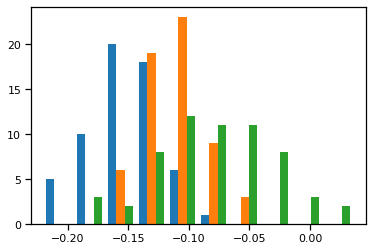

In [ ]:
A = pl.hist(zuco_text,stacked=False)
pl.show()

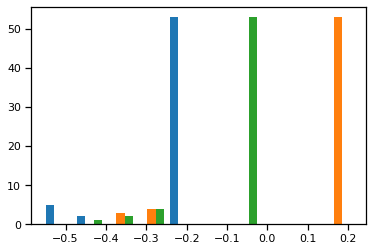

In [ ]:
B = pl.hist(zuco_eeg)
pl.show()

In [ ]:
wasserstein_distance(A[1], B[1])

0.15207181003960699

In [ ]:
n = 50  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)

In [ ]:
y_val_angry

array([0., 0., 1., ..., 2., 1., 1.])

In [ ]:
text = text_train_DCCA_trans[0:3000]

eeg= eeg_train_DCCA_trans[0:3000]

In [ ]:
print(text_val_ds_trans[0:5])
print(text_y_val_trans[0:5])

[[-0.05744364  0.6878857   0.3180092 ]
 [-0.1304414   0.86181521  0.91550887]
 [-0.13296519  0.88987261  0.33976126]
 [ 0.8865664   0.1785564   0.38933837]
 [-0.56929278  0.95375848  0.73928213]]
[0. 0. 0. 2. 0.]


In [ ]:
n = 50

M = ot.dist(eeg, text)
a, b = np.ones((n,)) / n, np.ones((n,)) / n 

ValueError: ignored

Text(0.5, 1.0, 'Cost matrix M')

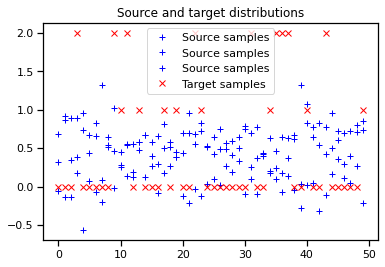

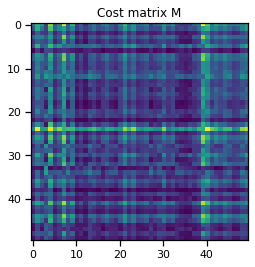

In [ ]:
pl.figure(1)
pl.plot(text, '+b', label='Source samples')
pl.plot(target, 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(M, interpolation='nearest')
pl.title('Cost matrix M')

IndexError: ignored

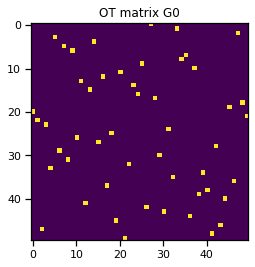

<Figure size 432x288 with 0 Axes>

In [ ]:
G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(text, target, G0, c=[.5, .5, 1])
pl.plot(text, '+b', label='Source samples')
pl.plot(target, 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

/usr/local/lib/python3.7/dist-packages/ot/bregman.py:484: RuntimeWarning: divide by zero encountered in true_divide
  v = b / KtransposeU
/usr/local/lib/python3.7/dist-packages/ot/bregman.py:484: RuntimeWarning: overflow encountered in true_divide
  v = b / KtransposeU
/usr/local/lib/python3.7/dist-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


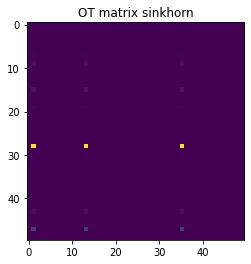

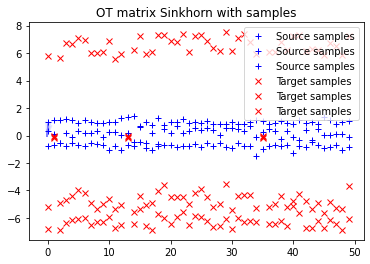

In [ ]:
lambd = 1e-1

Gs = ot.sinkhorn(a, b, M, lambd)

pl.figure(5)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix sinkhorn')

pl.figure(6)
ot.plot.plot2D_samples_mat(eeg, text, Gs, color=[.5, .5, 1])
pl.plot(eeg, '+b', label='Source samples')
pl.plot(text, 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix Sinkhorn with samples')

pl.show()

In [ ]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

In [ ]:
n = 100
x = np.arange(n, dtype=np.float64)

In [ ]:
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [ ]:
a=gauss(n, m=20, s=5)
b=gauss(n, m=60, s=10)
print(a.shape)

(306,)


In [ ]:
M = ot.dist(x.reshape((n,1)), x.reshape((n,1)))

In [ ]:
x.reshape((n,1))

In [ ]:
M/=M.max()

In [ ]:
text_train = text_train/np.linalg.norm(text_train)
text_val = text_val/np.linalg.norm(text_val)
text_test = text_test/np.linalg.norm(text_test)

In [ ]:
df_train_eeg = df_train_eeg.values
df_val_eeg = df_val_eeg.values
df_test_eeg = df_test_eeg.values

eeg_train = df_train_eeg[:, 1:]
eeg_val = df_val_eeg[:, 1:] 
eeg_test = df_test_eeg[:, 1:]

In [ ]:
y_train = y_train.flatten()
y_test = y_test.values
y_val = y_val.values

In [ ]:
y_train.shape

(306,)

In [ ]:
a=text_train.flatten()
b = eeg_train.flatten()


In [20]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd  

In [ ]:
len(y_train)

306

In [ ]:
y_train = y_train.flatten()


In [ ]:
X_val_arousal_text_tran.shape

(12000, 3)

In [143]:
#Text
X_test_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_lin_all_pred.txt')
X_val_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_lin_all_pred_val.txt')

#EEG
X_test_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_pred.txt')
X_val_eeg = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_pred_val.txt')

#Label
y_test_arousal = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_label.txt')
y_val_arousal = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_lin_all_label_val.txt')


In [17]:
len(y_val_arousal_tran)

12000

In [152]:
# x = X_val_arousal_eeg[0:3000]
# y = y_val_arousal[0:3000]
# text_eeg_train_ds = [eeg_val, eeg_val_DCCA_trans[0:244]]
# x = X_val_arousal_eeg_tran[0:200]
# y = y_val_arousal_tran[0:200]
# x = text_val
# y = y_val
x = X_val_text[0:1500]
y = y_val_arousal[0:1500]
tsne = TSNE(n_components=2, verbose=1, random_state=42, perplexity = 60, n_iter = 5000, learning_rate = 'auto')
z = tsne.fit_transform(x) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.264993
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.061161
[t-SNE] KL divergence after 3050 iterations: 0.446274


[Text(0.5, 1.0, 'EEG data T-SNE projection')]

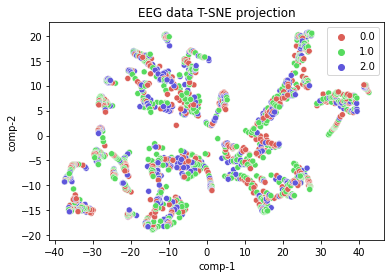

In [153]:
df = pd.DataFrame()
df["y"] = y.flatten()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="EEG data T-SNE projection") 

[Text(0.5, 1.0, 'EEG data T-SNE projection')]

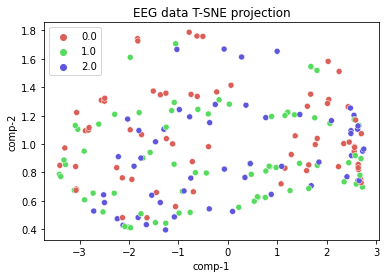

In [130]:
df = pd.DataFrame()
df["y"] = y.flatten()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="EEG data T-SNE projection") 

In [ ]:
#Text
X_train_arousal_text_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred_train.txt')
X_test_arousal_text_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred.txt')
X_val_arousal_text_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_pred_val.txt')

#EEG
X_train_arousal_eeg_tran= np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred_train.txt')
X_test_arousal_eeg_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred.txt')
X_val_arousal_eeg_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_pred_val.txt')

y_train_arousal_tran_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_label_train.txt')
y_test_arousal_tran_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_label.txt')
y_val_arousal_tran_text = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlytext_trans_all_label_val.txt')

#Label
y_train_arousal_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label_train.txt')
y_test_arousal_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label.txt')
y_val_arousal_tran = np.loadtxt('baselines/DCCA_ds/sentiment_baseline_onlyeeg_trans_all_label_val.txt')

In [ ]:
#Text
X_train_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_train.txt')
X_test_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_test.txt')
X_val_angry_text = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred_val.txt')

#EEG
X_train_angry_eeg= np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_train.txt')
X_test_angry_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_test.txt')
X_val_angry_eeg = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_pred2_val.txt')

#Label
y_train_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_train.txt')
y_test_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_test.txt')
y_val_angry = np.loadtxt('baselines/DCCA/sentiment_baseline_DCCA_only_all_label_val.txt')